# Comparing Object Detection Models for Video

In this tutorial we'll demonstrate how to use Pixeltable to do frame-by-frame object detection, made simple through Pixeltable's video-related functionality:
* automatic frame extraction
* running complex functions against frames (in this case, an object detection model)
* reassembling frames back into videos

We'll be working with a single video file (from Pixeltable's test data directory). Let's download that now:

In [1]:
import urllib.request

download_url = 'https://raw.github.com/mkornacker/pixeltable/master/docs/source/data/bangkok.mp4'
filename, _ = urllib.request.urlretrieve(download_url)

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Creating a tutorial directory and table

In Pixeltable, all data resides in tables, which in turn located inside directories.

Let's start by creating a client and a `video_tutorial` directory:

In [3]:
import pixeltable as pxt

cl = pxt.Client()
cl.create_dir('model_comparison', ignore_errors=True)

2024-01-10 11:27:12,555 INFO env env.py:172: found database postgresql://postgres:@/pixeltable?host=/Users/orm/Library/Caches/TemporaryItems/python_PostgresServer/dc4677b93f


2024-01-10 11:27:12,561 INFO env env.py:183: connecting to NOS


2024-01-10 11:27:12.596 | INFO     | nos.server:init:131 - Inference server already running (name=nos-inference-service-cpu, image=<Image: 'autonomi/nos:0.0.9-cpu'>, id=b4c529d9de2a).


2024-01-10 11:27:12,597 INFO env env.py:186: waiting for NOS


/Users/orm/repos/pixeltable/pixeltable/exec/expr_eval_node.py:6: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


2024-01-10 11:27:12,635 INFO env env.py:207: connecting to OpenAI


We create a table for our videos, with a single column:

In [4]:
video_path = 'model_comparison.videos'
frame_path = 'model_comparison.frames'
cl.drop_table(frame_path, ignore_errors=True)
cl.drop_table(video_path, ignore_errors=True)
v = cl.create_table(video_path, {'video': pxt.VideoType()})

In order to interact with the frames, we take advantage of Pixeltable's component view concept: we create a "view" of our video table that contains one row for each frame. Pixeltable provides the built-in `FrameIterator` class for this.

In [5]:
from pixeltable.iterators import FrameIterator
args = {'video': v.video, 'fps': 0}
f = cl.create_view(frame_path, v, iterator_class=FrameIterator, iterator_args=args)

created view frames with 0 rows, 0 exceptions


The `fps` parameter determines the frame rate, with `0` indicating the native frame rate.

Running this creates a view with six columns:
- `frame_idx`, `pos_msec`, `pos_frame` and `frame` are created by the `FrameIterator` class.
- `pos` is a system column in every component view
- `video` is the column for our base table (all base table columns are visible in the view, to facilitate querying)

Note that you could create additional views on the `videos` table, each with its own frame rate.

In [6]:
f

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
video,video,


We now insert a single row containing the name of the video file we just downloaded, which is expanded into 462 frames/rows in the `frames` view.

In general, `insert()` takes as its first argument a list of rows, each of which is a dictionary mapping column names to column values.

In [7]:
v.insert([{'video': filename}])

Inserting rows into table: 0rows [00:00, ?rows/s]

Inserting rows into table: 1rows [00:00, 446.25rows/s]

Inserting rows into table: 0rows [00:00, ?rows/s]

Inserting rows into table: 462rows [00:00, 17948.12rows/s]

inserted 463 rows with 0 errors 


UpdateStatus(num_rows=463, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

We loaded a video that shows a busy intersection in Bangkok. Let's look at the first frame:

frame,width,height
,1280,720

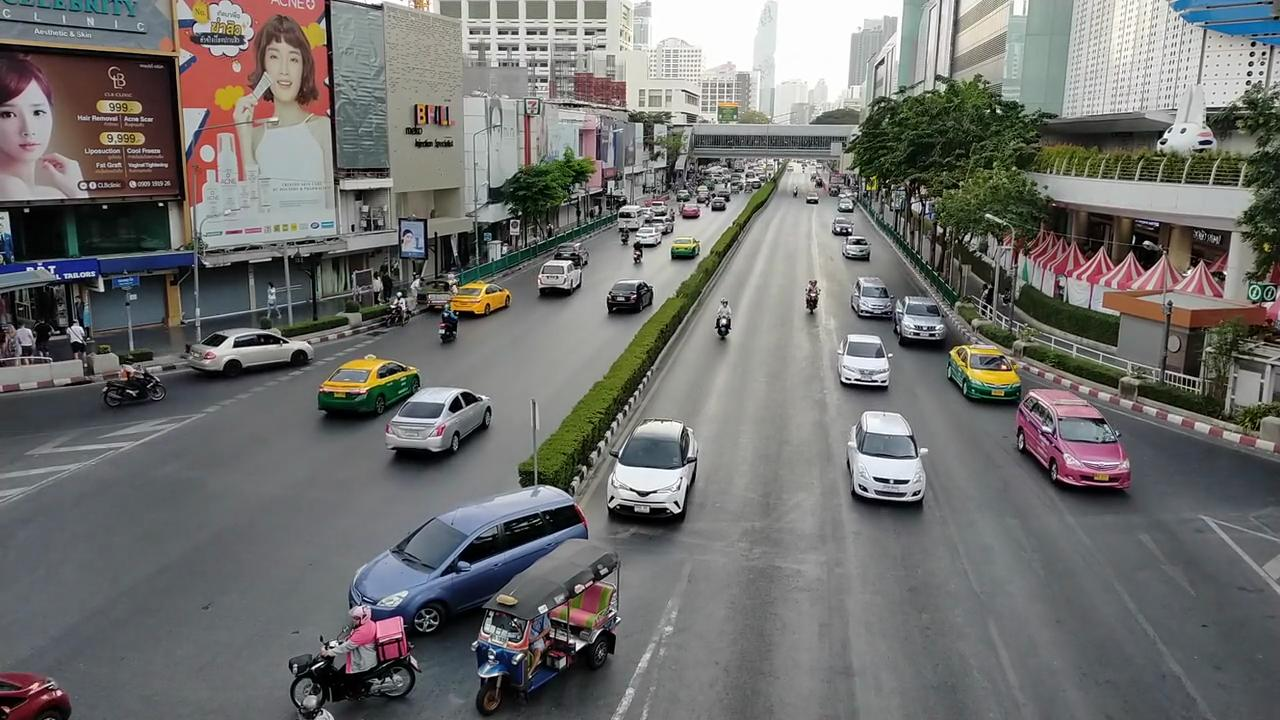

In [8]:
f.where(f.pos == 200).select(f.frame, f.frame.width, f.frame.height).show(1)

When we create the `frames` view, Pixeltable does not physically store the frames. Instead, Pixeltable re-extracts the frames on retrieval using the `pos` column value, which can be done very efficiently and avoids any storage overhead (which would be very substantial for video frames).

## Object detection with Pixeltable

Pixeltable comes pre-packaged with a number of object detection models. We're going to explore one from the YoloX family.

In [9]:
from pixeltable.functions.nos.object_detection_2d import yolox_tiny as model1

We can then use `model1()` in the Pixeltable index operator using standard Python function call syntax:

frame  \
0  <PIL.Image.Image image mode=RGB size=1280x720 ...   

                                               col_1  
0  {'bboxes': [[0.76116943359375, 556.28472900390...
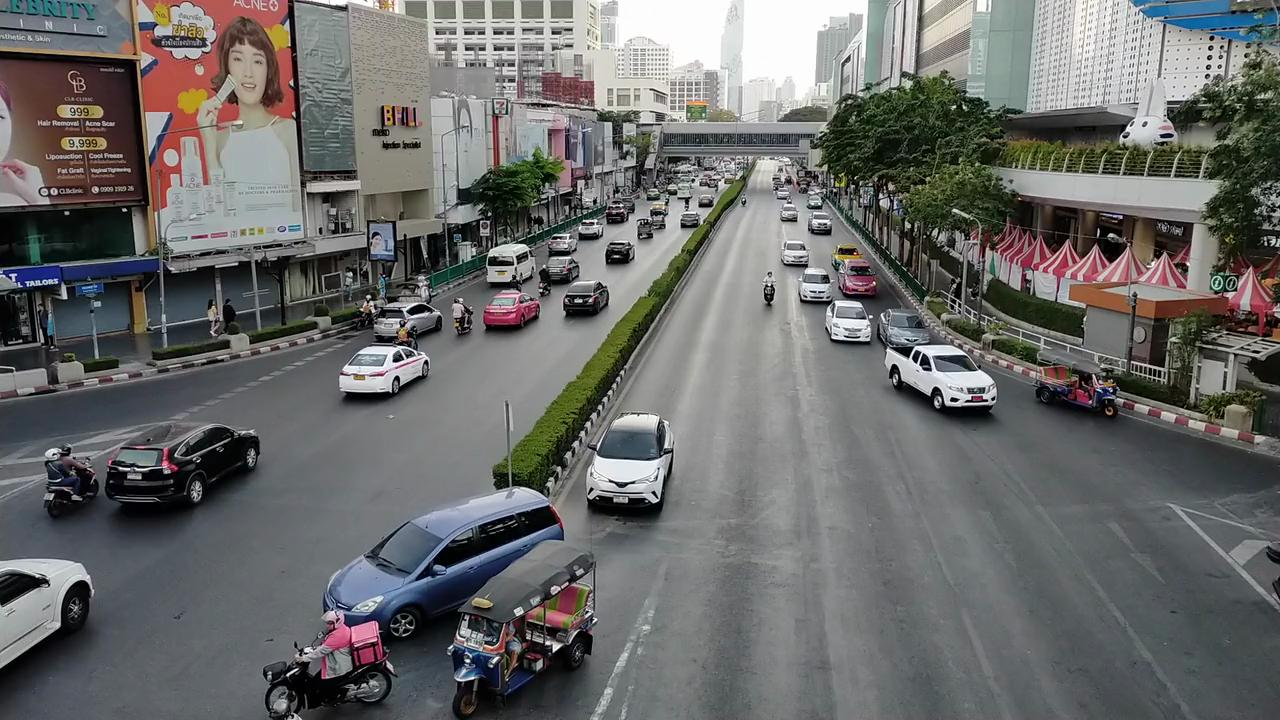

In [10]:
f.where(f.frame_idx == 0).select(f.frame, model1(f.frame)).show(1)

This works as expected, and we now add the detections as a computed column `detections_1` to the table (there'll be a `detections_2` later).

Running model inference is generally an expensive operation; adding it as a computed column makes sure it only runs once, at the time the row is inserted. After that, the result is available as part of the stored table data.

Note that for computed columns of any type other than `image`, the computed values are **always** stored (ie, `stored=True`).

In [11]:
f.add_column(detections_1=model1(f.frame))

Computing cells:   0%|          | 0/462 [00:00<?, ?cells/s]

Computing cells:   2%|▏         | 8/462 [00:04<04:26,  1.71cells/s]

Computing cells:   3%|▎         | 12/462 [00:06<04:21,  1.72cells/s]

Computing cells:   3%|▎         | 16/462 [00:09<04:17,  1.73cells/s]

Computing cells:   4%|▍         | 20/462 [00:11<04:16,  1.73cells/s]

Computing cells:   5%|▌         | 24/462 [00:13<04:14,  1.72cells/s]

Computing cells:   6%|▌         | 28/462 [00:16<04:10,  1.73cells/s]

Computing cells:   7%|▋         | 32/462 [00:18<04:08,  1.73cells/s]

Computing cells:   8%|▊         | 36/462 [00:20<04:06,  1.73cells/s]

Computing cells:   9%|▊         | 40/462 [00:23<04:03,  1.73cells/s]

Computing cells:  10%|▉         | 44/462 [00:25<04:01,  1.73cells/s]

Computing cells:  10%|█         | 48/462 [00:27<03:59,  1.73cells/s]

Computing cells:  11%|█▏        | 52/462 [00:30<03:58,  1.72cells/s]

Computing cells:  12%|█▏        | 56/462 [00:32<03:55,  1.73cells/s]

Computing cells:  13%|█▎        | 60/462 [00:34<03:53,  1.72cells/s]

Computing cells:  14%|█▍        | 64/462 [00:37<03:51,  1.72cells/s]

Computing cells:  15%|█▍        | 68/462 [00:39<03:48,  1.72cells/s]

Computing cells:  16%|█▌        | 72/462 [00:41<03:46,  1.72cells/s]

Computing cells:  16%|█▋        | 76/462 [00:44<03:43,  1.73cells/s]

Computing cells:  17%|█▋        | 80/462 [00:46<03:39,  1.74cells/s]

Computing cells:  18%|█▊        | 84/462 [00:48<03:37,  1.73cells/s]

Computing cells:  19%|█▉        | 88/462 [00:50<03:35,  1.74cells/s]

Computing cells:  20%|█▉        | 92/462 [00:53<03:31,  1.75cells/s]

Computing cells:  21%|██        | 96/462 [00:55<03:30,  1.74cells/s]

Computing cells:  22%|██▏       | 100/462 [00:57<03:28,  1.74cells/s]

Computing cells:  23%|██▎       | 104/462 [01:00<03:26,  1.74cells/s]

Computing cells:  23%|██▎       | 108/462 [01:02<03:23,  1.74cells/s]

Computing cells:  24%|██▍       | 112/462 [01:04<03:23,  1.72cells/s]

Computing cells:  25%|██▌       | 116/462 [01:07<03:20,  1.73cells/s]

Computing cells:  26%|██▌       | 120/462 [01:09<03:19,  1.72cells/s]

Computing cells:  27%|██▋       | 124/462 [01:11<03:15,  1.73cells/s]

Computing cells:  28%|██▊       | 128/462 [01:14<03:13,  1.72cells/s]

Computing cells:  29%|██▊       | 132/462 [01:16<03:11,  1.73cells/s]

Computing cells:  29%|██▉       | 136/462 [01:18<03:09,  1.72cells/s]

Computing cells:  30%|███       | 140/462 [01:21<03:07,  1.72cells/s]

Computing cells:  31%|███       | 144/462 [01:23<03:05,  1.72cells/s]

Computing cells:  32%|███▏      | 148/462 [01:25<03:06,  1.68cells/s]

Computing cells:  33%|███▎      | 152/462 [01:28<03:02,  1.69cells/s]

Computing cells:  34%|███▍      | 156/462 [01:30<02:59,  1.70cells/s]

Computing cells:  35%|███▍      | 160/462 [01:32<02:58,  1.69cells/s]

Computing cells:  35%|███▌      | 164/462 [01:35<03:00,  1.65cells/s]

Computing cells:  36%|███▋      | 168/462 [01:38<03:02,  1.61cells/s]

Computing cells:  37%|███▋      | 172/462 [01:40<02:59,  1.62cells/s]

Computing cells:  38%|███▊      | 176/462 [01:42<02:55,  1.63cells/s]

Computing cells:  39%|███▉      | 180/462 [01:45<02:51,  1.64cells/s]

Computing cells:  40%|███▉      | 184/462 [01:47<02:51,  1.62cells/s]

Computing cells:  41%|████      | 188/462 [01:50<02:46,  1.64cells/s]

Computing cells:  42%|████▏     | 192/462 [01:52<02:42,  1.66cells/s]

Computing cells:  42%|████▏     | 196/462 [01:54<02:38,  1.68cells/s]

Computing cells:  43%|████▎     | 200/462 [01:57<02:35,  1.69cells/s]

Computing cells:  44%|████▍     | 204/462 [01:59<02:32,  1.69cells/s]

Computing cells:  45%|████▌     | 208/462 [02:02<02:31,  1.68cells/s]

Computing cells:  46%|████▌     | 212/462 [02:04<02:28,  1.69cells/s]

Computing cells:  47%|████▋     | 216/462 [02:06<02:25,  1.69cells/s]

Computing cells:  48%|████▊     | 220/462 [02:09<02:21,  1.71cells/s]

Computing cells:  48%|████▊     | 224/462 [02:11<02:19,  1.71cells/s]

Computing cells:  49%|████▉     | 228/462 [02:13<02:17,  1.71cells/s]

Computing cells:  50%|█████     | 232/462 [02:16<02:14,  1.71cells/s]

Computing cells:  51%|█████     | 236/462 [02:18<02:12,  1.71cells/s]

Computing cells:  52%|█████▏    | 240/462 [02:20<02:10,  1.71cells/s]

Computing cells:  53%|█████▎    | 244/462 [02:23<02:08,  1.70cells/s]

Computing cells:  54%|█████▎    | 248/462 [02:25<02:05,  1.71cells/s]

Computing cells:  55%|█████▍    | 252/462 [02:27<02:02,  1.71cells/s]

Computing cells:  55%|█████▌    | 256/462 [02:30<01:59,  1.72cells/s]

Computing cells:  56%|█████▋    | 260/462 [02:32<01:59,  1.69cells/s]

Computing cells:  57%|█████▋    | 264/462 [02:34<01:57,  1.69cells/s]

Computing cells:  58%|█████▊    | 268/462 [02:37<01:54,  1.70cells/s]

Computing cells:  59%|█████▉    | 272/462 [02:39<01:52,  1.70cells/s]

Computing cells:  60%|█████▉    | 276/462 [02:41<01:49,  1.69cells/s]

Computing cells:  61%|██████    | 280/462 [02:44<01:46,  1.71cells/s]

Computing cells:  61%|██████▏   | 284/462 [02:46<01:44,  1.71cells/s]

Computing cells:  62%|██████▏   | 288/462 [02:48<01:41,  1.71cells/s]

Computing cells:  63%|██████▎   | 292/462 [02:51<01:40,  1.70cells/s]

Computing cells:  64%|██████▍   | 296/462 [02:53<01:37,  1.71cells/s]

Computing cells:  65%|██████▍   | 300/462 [02:55<01:34,  1.71cells/s]

Computing cells:  66%|██████▌   | 304/462 [02:58<01:32,  1.71cells/s]

Computing cells:  67%|██████▋   | 308/462 [03:00<01:30,  1.71cells/s]

Computing cells:  68%|██████▊   | 312/462 [03:03<01:30,  1.66cells/s]

Computing cells:  68%|██████▊   | 316/462 [03:06<01:32,  1.59cells/s]

Computing cells:  69%|██████▉   | 320/462 [03:08<01:29,  1.59cells/s]

Computing cells:  70%|███████   | 324/462 [03:10<01:25,  1.61cells/s]

Computing cells:  71%|███████   | 328/462 [03:13<01:22,  1.62cells/s]

Computing cells:  72%|███████▏  | 332/462 [03:15<01:19,  1.64cells/s]

Computing cells:  73%|███████▎  | 336/462 [03:18<01:15,  1.67cells/s]

Computing cells:  74%|███████▎  | 340/462 [03:20<01:13,  1.67cells/s]

Computing cells:  74%|███████▍  | 344/462 [03:22<01:10,  1.68cells/s]

Computing cells:  75%|███████▌  | 348/462 [03:25<01:07,  1.69cells/s]

Computing cells:  76%|███████▌  | 352/462 [03:27<01:05,  1.67cells/s]

Computing cells:  77%|███████▋  | 356/462 [03:29<01:03,  1.67cells/s]

Computing cells:  78%|███████▊  | 360/462 [03:32<01:01,  1.66cells/s]

Computing cells:  79%|███████▉  | 364/462 [03:34<00:59,  1.65cells/s]

Computing cells:  80%|███████▉  | 368/462 [03:37<00:57,  1.64cells/s]

Computing cells:  81%|████████  | 372/462 [03:39<00:55,  1.61cells/s]

Computing cells:  81%|████████▏ | 376/462 [03:42<00:53,  1.60cells/s]

Computing cells:  82%|████████▏ | 380/462 [03:44<00:51,  1.60cells/s]

Computing cells:  83%|████████▎ | 384/462 [03:47<00:48,  1.62cells/s]

Computing cells:  84%|████████▍ | 388/462 [03:49<00:45,  1.63cells/s]

Computing cells:  85%|████████▍ | 392/462 [03:52<00:42,  1.66cells/s]

Computing cells:  86%|████████▌ | 396/462 [03:54<00:39,  1.66cells/s]

Computing cells:  87%|████████▋ | 400/462 [03:56<00:37,  1.67cells/s]

Computing cells:  87%|████████▋ | 404/462 [03:59<00:34,  1.66cells/s]

Computing cells:  88%|████████▊ | 408/462 [04:01<00:32,  1.67cells/s]

Computing cells:  89%|████████▉ | 412/462 [04:03<00:29,  1.69cells/s]

Computing cells:  90%|█████████ | 416/462 [04:06<00:26,  1.71cells/s]

Computing cells:  91%|█████████ | 420/462 [04:08<00:24,  1.71cells/s]

Computing cells:  92%|█████████▏| 424/462 [04:10<00:22,  1.71cells/s]

Computing cells:  93%|█████████▎| 428/462 [04:13<00:19,  1.72cells/s]

Computing cells:  94%|█████████▎| 432/462 [04:15<00:17,  1.72cells/s]

Computing cells:  94%|█████████▍| 436/462 [04:17<00:15,  1.72cells/s]

Computing cells:  95%|█████████▌| 440/462 [04:20<00:12,  1.73cells/s]

Computing cells:  96%|█████████▌| 444/462 [04:22<00:10,  1.74cells/s]

Computing cells:  97%|█████████▋| 448/462 [04:24<00:08,  1.72cells/s]

Computing cells:  98%|█████████▊| 452/462 [04:27<00:05,  1.73cells/s]

Computing cells:  99%|█████████▊| 456/462 [04:29<00:03,  1.73cells/s]

Computing cells: 100%|█████████▉| 460/462 [04:31<00:01,  1.73cells/s]

Computing cells: 100%|██████████| 462/462 [04:32<00:00,  1.71cells/s]

Computing cells: 100%|██████████| 462/462 [04:32<00:00,  1.69cells/s]

added 462 column values with 0 errors


UpdateStatus(num_rows=462, num_computed_values=462, num_excs=0, updated_cols=[], cols_with_excs=[])

The column is now part of `f`'s schema:

In [12]:
f

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
detections_1,json,nos.object_detection_2d.yolox_tiny(frame)
video,video,


We can create a simple user-defined function `draw_boxes()` to visualize detections:

In [13]:
import PIL.ImageDraw

@pxt.udf(return_type=pxt.ImageType(), param_types=[pxt.ImageType(), pxt.JsonType()])
def draw_boxes(img, boxes):
    result = img.copy()
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)
    return result

This function takes two arguments:
- `img` has type `image` and receives an instance of `PIL.Image.Image`
- `boxes` has type `json` and receives a JSON-serializable structure, in this case a list of 4-element lists of floats

When we "call" this function, we need to pass in the frame and the bounding boxes identified in that frame. The latter can be selected with the JSON path expression `t.detections.boxes`:

frame,col_1
,

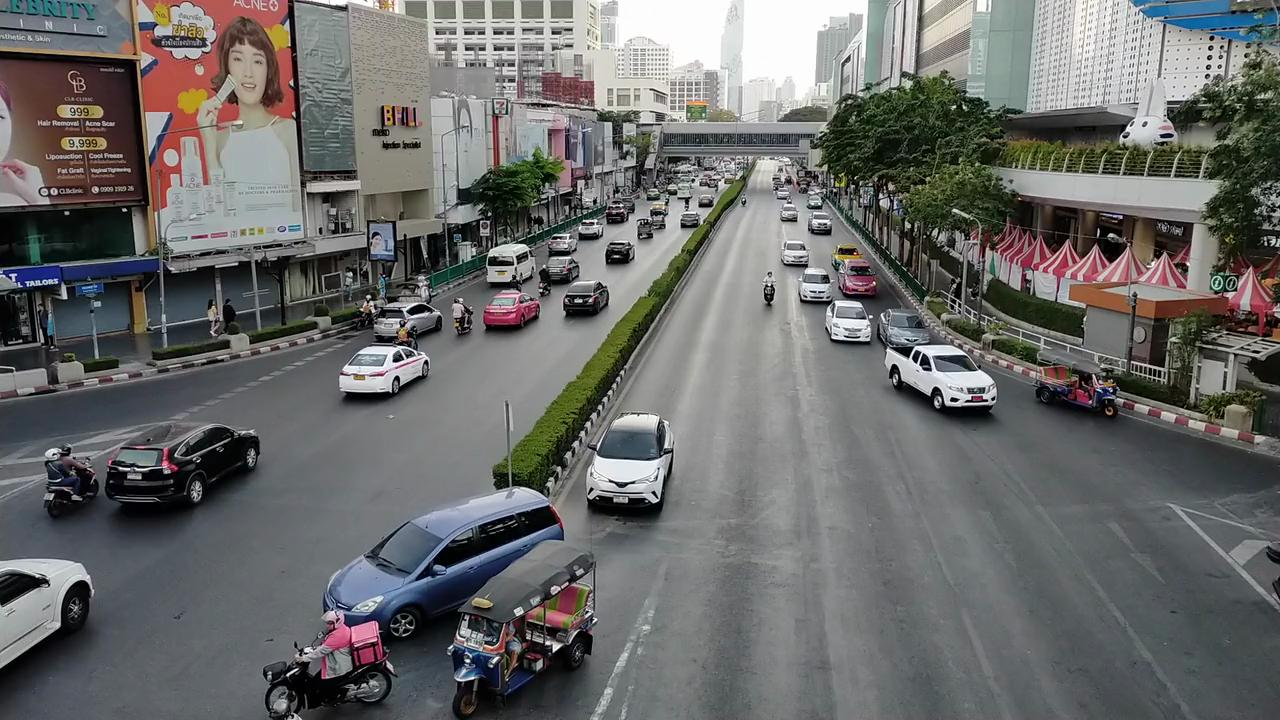
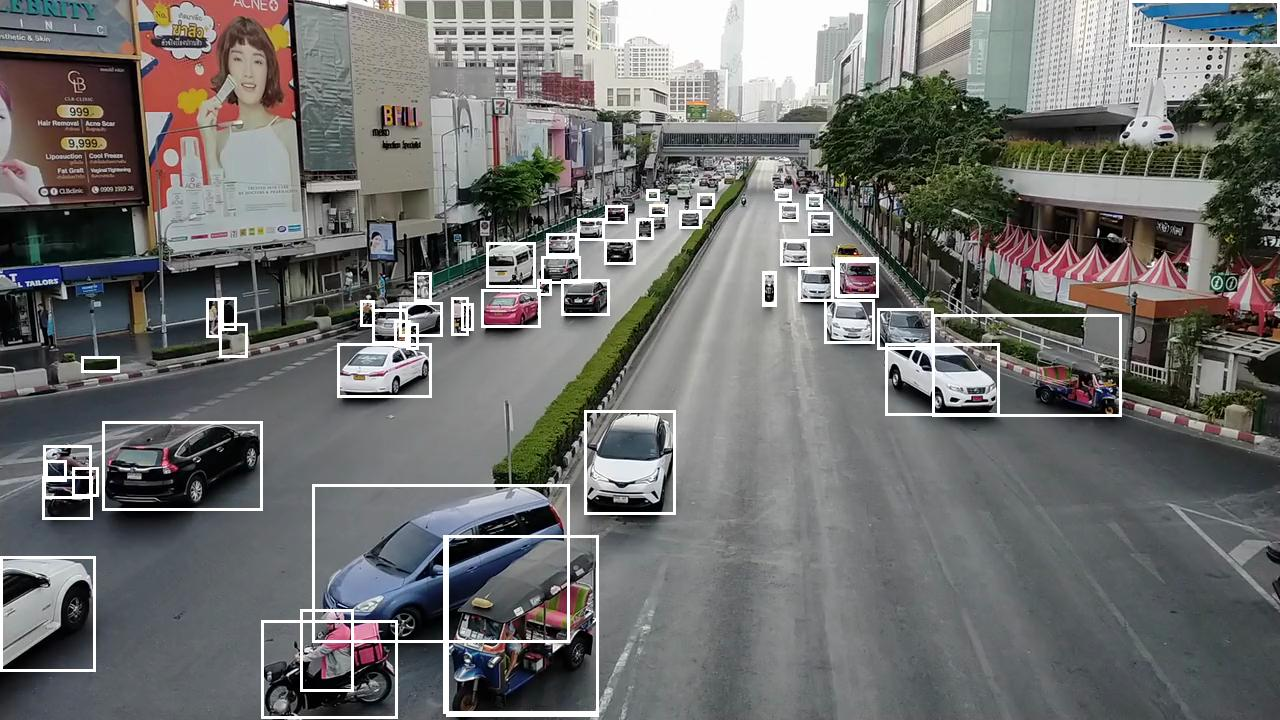

In [14]:
f.where(f.pos == 0).select(f.frame, draw_boxes(f.frame, f.detections_1.bboxes)).show(1)

Looking at individual frames gives us some idea of how well our detection algorithm works, but it would be more instructive to turn the visualization output back into a video.

We do that with the built-in function `make_video()`, which is an aggregation function that takes a frame index (actually: any expression that can be used to order the frames; a timestamp would also work) and an image, and then assembles the sequence of images into a video:

In [15]:
f.select(pxt.make_video(f.pos, draw_boxes(f.frame, f.detections_1.bboxes))).group_by(v).show()

col_0
""


## Comparing multiple detection models

The output of YoloX-tiny seems reasonable, but we're curious how much better a slightly larger model, such as YoloX-medium, would be for our particular use case. Instead of creating another table and reloading the data, etc., we can simply add another column to our existing table:

In [16]:
from pixeltable.functions.nos.object_detection_2d import yolox_medium as model2

We're using the alternative form of adding table columns:

In [17]:
f['detections_2'] = model2(f.frame)

Computing cells:   0%|          | 0/462 [00:00<?, ?cells/s]

Computing cells:   2%|▏         | 8/462 [00:13<12:42,  1.68s/cells]

Computing cells:   3%|▎         | 12/462 [00:18<11:34,  1.54s/cells]

Computing cells:   3%|▎         | 16/462 [00:24<10:56,  1.47s/cells]

Computing cells:   4%|▍         | 20/462 [00:29<10:36,  1.44s/cells]

Computing cells:   5%|▌         | 24/462 [00:35<10:16,  1.41s/cells]

Computing cells:   6%|▌         | 28/462 [00:40<10:00,  1.38s/cells]

Computing cells:   7%|▋         | 32/462 [00:45<09:48,  1.37s/cells]

Computing cells:   8%|▊         | 36/462 [00:51<09:39,  1.36s/cells]

Computing cells:   9%|▊         | 40/462 [00:56<09:33,  1.36s/cells]

Computing cells:  10%|▉         | 44/462 [01:01<09:23,  1.35s/cells]

Computing cells:  10%|█         | 48/462 [01:07<09:16,  1.34s/cells]

Computing cells:  11%|█▏        | 52/462 [01:12<09:11,  1.34s/cells]

Computing cells:  12%|█▏        | 56/462 [01:17<09:04,  1.34s/cells]

Computing cells:  13%|█▎        | 60/462 [01:23<08:57,  1.34s/cells]

Computing cells:  14%|█▍        | 64/462 [01:28<08:53,  1.34s/cells]

Computing cells:  15%|█▍        | 68/462 [01:33<08:46,  1.34s/cells]

Computing cells:  16%|█▌        | 72/462 [01:39<08:44,  1.34s/cells]

Computing cells:  16%|█▋        | 76/462 [01:44<08:39,  1.35s/cells]

Computing cells:  17%|█▋        | 80/462 [01:50<08:33,  1.35s/cells]

Computing cells:  18%|█▊        | 84/462 [01:55<08:28,  1.34s/cells]

Computing cells:  19%|█▉        | 88/462 [02:00<08:20,  1.34s/cells]

Computing cells:  20%|█▉        | 92/462 [02:06<08:15,  1.34s/cells]

Computing cells:  21%|██        | 96/462 [02:11<08:10,  1.34s/cells]

Computing cells:  22%|██▏       | 100/462 [02:17<08:06,  1.34s/cells]

Computing cells:  23%|██▎       | 104/462 [02:22<08:00,  1.34s/cells]

Computing cells:  23%|██▎       | 108/462 [02:27<07:52,  1.34s/cells]

Computing cells:  24%|██▍       | 112/462 [02:32<07:44,  1.33s/cells]

Computing cells:  25%|██▌       | 116/462 [02:38<07:41,  1.33s/cells]

Computing cells:  26%|██▌       | 120/462 [02:43<07:37,  1.34s/cells]

Computing cells:  27%|██▋       | 124/462 [02:49<07:39,  1.36s/cells]

Computing cells:  28%|██▊       | 128/462 [02:54<07:36,  1.37s/cells]

Computing cells:  29%|██▊       | 132/462 [03:00<07:29,  1.36s/cells]

Computing cells:  29%|██▉       | 136/462 [03:05<07:20,  1.35s/cells]

Computing cells:  30%|███       | 140/462 [03:10<07:14,  1.35s/cells]

Computing cells:  31%|███       | 144/462 [03:16<07:06,  1.34s/cells]

Computing cells:  32%|███▏      | 148/462 [03:21<07:00,  1.34s/cells]

Computing cells:  33%|███▎      | 152/462 [03:26<06:55,  1.34s/cells]

Computing cells:  34%|███▍      | 156/462 [03:32<06:48,  1.34s/cells]

Computing cells:  35%|███▍      | 160/462 [03:37<06:43,  1.34s/cells]

Computing cells:  35%|███▌      | 164/462 [03:42<06:38,  1.34s/cells]

Computing cells:  36%|███▋      | 168/462 [03:48<06:32,  1.34s/cells]

Computing cells:  37%|███▋      | 172/462 [03:53<06:27,  1.33s/cells]

Computing cells:  38%|███▊      | 176/462 [03:59<06:23,  1.34s/cells]

Computing cells:  39%|███▉      | 180/462 [04:04<06:16,  1.34s/cells]

Computing cells:  40%|███▉      | 184/462 [04:09<06:10,  1.33s/cells]

Computing cells:  41%|████      | 188/462 [04:14<06:05,  1.33s/cells]

Computing cells:  42%|████▏     | 192/462 [04:20<06:02,  1.34s/cells]

Computing cells:  42%|████▏     | 196/462 [04:25<05:58,  1.35s/cells]

Computing cells:  43%|████▎     | 200/462 [04:31<05:54,  1.35s/cells]

Computing cells:  44%|████▍     | 204/462 [04:36<05:52,  1.36s/cells]

Computing cells:  45%|████▌     | 208/462 [04:42<05:49,  1.38s/cells]

Computing cells:  46%|████▌     | 212/462 [04:48<05:46,  1.39s/cells]

Computing cells:  47%|████▋     | 216/462 [04:53<05:39,  1.38s/cells]

Computing cells:  48%|████▊     | 220/462 [04:59<05:32,  1.38s/cells]

Computing cells:  48%|████▊     | 220/462 [05:00<05:30,  1.36s/cells]

KeyboardInterrupt: 

We don't have ground truth data yet, but visualizing the output in the form of a video gives us some clue how much a smaller model affects the result:

In [ ]:
f.select(
    pxt.make_video(f.frame_idx, draw_boxes(f.frame, f.detections_1.bboxes)),
    pxt.make_video(f.frame_idx, draw_boxes(f.frame, f.detections_2.bboxes)),
).group_by(v).show(1)

# Evaluating the models against ground truth

In order to have something to base the evaluation on, let's generate some 'ground truth' data by running the largest YoloX model available.

In [ ]:
from pixeltable.functions.nos.object_detection_2d import yolox_xlarge

In [ ]:
f['gt'] = yolox_xlarge(f.frame)

We now have two columns with detections, `detections_1` and `detections_2`, and one column `gt` with synthetic ground-truth data, which we're going to use as the basis for evaluation:

In [ ]:
f

We're going to be evaluating the generated detections with the commonly-used [mean average precision metric](https://learnopencv.com/mean-average-precision-map-object-detection-model-evaluation-metric/) (mAP).

The mAP metric is based on per-frame metrics, such as true and false positives per detected class, which are then aggregated into a single (per-class) number. In Pixeltable, functionality is available via the `eval_detections()` and `mean_ap()` built-in functions:

In [ ]:
from pixeltable.functions.eval import eval_detections, mean_ap

The `eval_detections()` function computes the required per-frame metrics, and we're going to add those as computed columns in order to cache the output (and avoid having to re-type the call to `eval_detections()` repeatedly later).

In [ ]:
f['eval_1'] = eval_detections(
    f.detections_1.bboxes, f.detections_1.labels, f.detections_1.scores, f.gt.bboxes, f.gt.labels)

In [ ]:
f['eval_2'] = eval_detections(
    f.detections_2.bboxes, f.detections_2.labels, f.detections_2.scores, f.gt.bboxes, f.gt.labels)

Let's take a look at the output:

In [ ]:
f.select(f.eval_1, f.eval_2).show(1)

The computation of the mAP metric is now simply a query over the evaluation output, aggregated with the `mean_ap()` function:

In [ ]:
f.select(mean_ap(f.eval_1), mean_ap(f.eval_2)).show(1)

This two-step process allows you to compute mAP at every granularity: over your entire dataset, only for specific videos, only for videos that pass a certain filter, etc. Moreover, you can compute this metric any time, not just during training, and use it to guide your understand of your dataset and how it affects the quality of your models.

# Exporting Detection Data as a COCO Dataset

In [ ]:
@pxt.udf(return_type=pxt.JsonType(nullable=False), param_types=[pxt.JsonType(nullable=False)])
def yolo_to_coco(detections):
    bboxes, labels = detections['bboxes'], detections['labels']
    num_annotations = len(detections['bboxes'])
    assert num_annotations == len(detections['labels'])
    result = []
    for i in range(num_annotations):
        bbox = bboxes[i]
        ann = {
            'bbox': [round(bbox[0]), round(bbox[1]), round(bbox[2] - bbox[0]), round(bbox[3] - bbox[1])],
            'category': labels[i],
        }
        result.append(ann)
    return result